In [ ]:
import torch
from ultralytics import YOLO
from attacks import disappearance_dag_attack,targeted_dag_attack
from util import compare_original_and_adversarial


In [2]:
model = YOLO("yolov8n_road.pt")
image_path = "im2.jpg"

In [4]:
adv_image = disappearance_dag_attack(image_path, raw_model_path="yolov8n_road.pt", high_level_model_path="yolov8n_road.pt",num_iterations=20, gamma=0.003)


0: 640x640 2 cars, 1 trafficLight-Green, 1 truck, 323.3ms
Speed: 0.0ms preprocess, 323.3ms inference, 16.5ms postprocess per image at shape (1, 3, 640, 640)
Iteration 0: #rows_to_attack=4660, loss=-27.7625

0: 640x640 (no detections), 285.1ms
Speed: 0.0ms preprocess, 285.1ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)
Iteration 1: no rows above threshold => stopping early.


Running prediction on original tensor...



0: 640x640 2 cars, 1 trafficLight-Green, 1 truck, 334.8ms
Speed: 0.0ms preprocess, 334.8ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)
Running prediction on loaded adversarial tensor...

0: 640x640 (no detections), 202.8ms
Speed: 0.0ms preprocess, 202.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


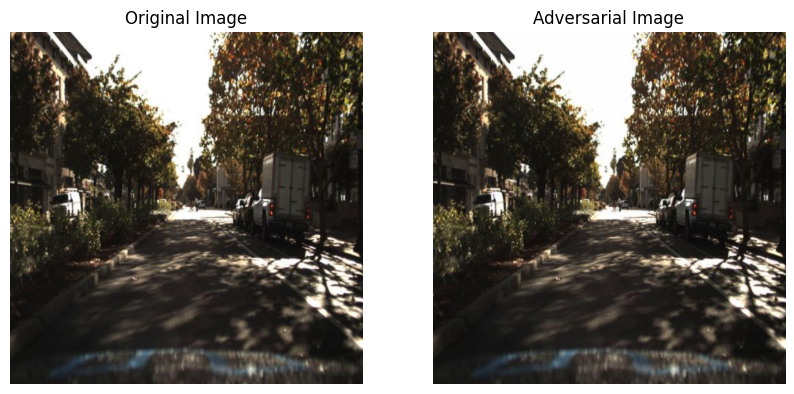

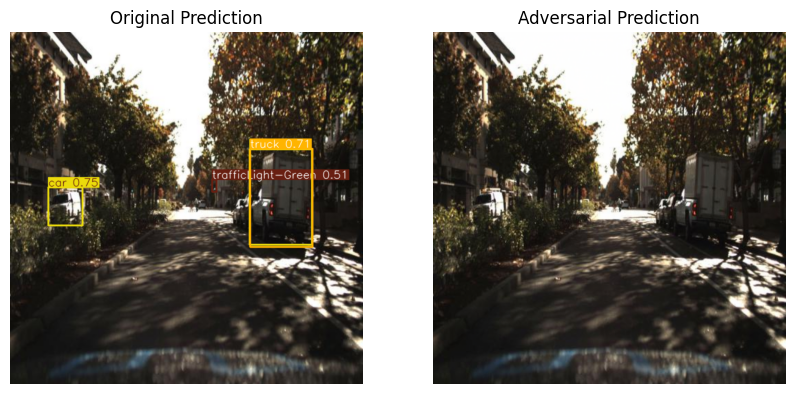

In [5]:

compare_original_and_adversarial(model ,image_path,adv_image,0.5)

In [6]:
adv_image_targeted = targeted_dag_attack(
    image_path=image_path,
    raw_model_path="yolov8n_road.pt",
    high_level_model_path="yolov8n_road.pt",
    adversarial_class=0,
    num_iterations=20,
    gamma=0.003,
    conf_threshold=0.5,
    device='cpu')


0: 640x640 2 cars, 1 trafficLight-Green, 1 truck, 204.7ms
Speed: 0.0ms preprocess, 204.7ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)
Original classes above conf=0.5: {1, 10, 4}

0: 640x640 (no detections), 224.0ms
Speed: 0.0ms preprocess, 224.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)
Iteration 0: #rows_to_attack=4660, loss=-27.7528

0: 640x640 2 cars, 235.6ms
Speed: 0.0ms preprocess, 235.6ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)
Iteration 1: #rows_to_attack=3946, loss=-11.6521

0: 640x640 (no detections), 228.1ms
Speed: 0.0ms preprocess, 228.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)
Iteration 2: #rows_to_attack=4189, loss=-11.6686

0: 640x640 (no detections), 223.5ms
Speed: 0.0ms preprocess, 223.5ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)
Iteration 3: #rows_to_attack=3745, loss=-0.6615

0: 640x640 (no detections), 313.4ms
Speed: 0.0ms preprocess, 313.4ms inf

Running prediction on original tensor...

0: 640x640 2 cars, 1 trafficLight-Green, 1 truck, 264.5ms
Speed: 0.0ms preprocess, 264.5ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)
Running prediction on loaded adversarial tensor...

0: 640x640 (no detections), 220.3ms
Speed: 0.0ms preprocess, 220.3ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 640)


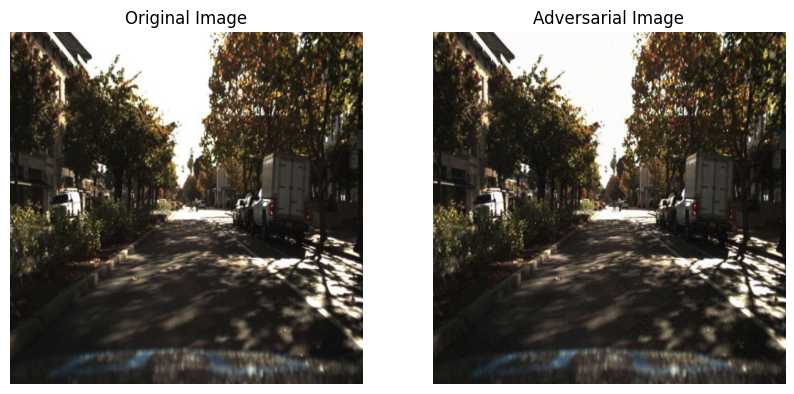

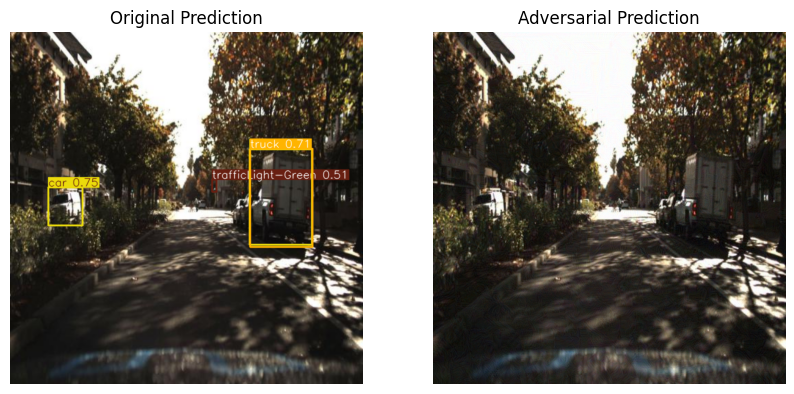

In [7]:
compare_original_and_adversarial(model ,image_path,adv_image_targeted ,0.5)